In [ ]:
!pip install gdown
!gdown --id 1IQ90jtnITrrcBWsFjF8jkFXF7LAxDqLF

Downloading...
From: https://drive.google.com/uc?id=1IQ90jtnITrrcBWsFjF8jkFXF7LAxDqLF
To: /content/archive.zip
650MB [00:05, 119MB/s] 


In [ ]:
%%time
import zipfile
zip_ref = zipfile.ZipFile("archive.zip", 'r')
zip_ref.extractall("./scenery")
zip_ref.close()

CPU times: user 2.87 s, sys: 799 ms, total: 3.67 s
Wall time: 8.58 s


In [ ]:
import matplotlib.pyplot as plt
def show_images(images, figsize=(20,10), columns = 5):
  plt.figure(figsize=figsize)
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.imshow(image)

In [ ]:
import os
IMAGES_PATH="./scenery"
file_names=os.listdir(IMAGES_PATH)
print(f"number of images: {len(file_names)}")

number of images: 4319


In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
import os
from os import listdir
from os.path import splitext
import numpy as np
from PIL import Image
import pickle as pk
from tqdm import tqdm
def read_img_file(f):
    img = Image.open(f)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

def resize_img_to_array(img, img_shape):
    img_array = np.array(
        img.resize(
            img_shape, 
            Image.ANTIALIAS
        )
    )    
    return img_array

def get_features(img):
    img_width, img_height = 224, 224
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    expanded_img_array = np.expand_dims(np_img, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    X_conv = model.predict(preprocessed_img)
    image_features=X_conv[0]
    image_features /=  np.linalg.norm(image_features)
    return image_features
model = ResNet50(weights='imagenet', include_top=False,input_shape=(224, 224, 3),pooling='max')

def generate_resnet_features():
    all_image_features=[]
    image_filenames=listdir(IMAGES_PATH)
    image_ids=set(map(lambda el: splitext(el)[0],image_filenames))
    try:
       all_image_features=pk.load(open("resnet_image_features.pkl", "rb"))
    except (OSError, IOError) as e:
       print("file_not_found")

    def exists_in_all_image_features(image_id):
        for image in all_image_features:
            if image['image_id'] == image_id:
                # print("skipping "+ str(image_id))
                return True
        return False

    def exists_in_image_folder(image_id):
        if image_id in image_ids:
                return True
        return False   

    def sync_resnet_image_features():
        for_deletion=[]
        for i in range(len(all_image_features)):
            if not exists_in_image_folder(all_image_features[i]['image_id']):
                print("deleting "+ str(all_image_features[i]['image_id']))
                for_deletion.append(i)
        for i in reversed(for_deletion):
            del all_image_features[i]

    sync_resnet_image_features()
    for image_filename in tqdm(image_filenames):
        image_id=splitext(image_filename)[0]
        if exists_in_all_image_features(image_id):
            continue
        img_arr = read_img_file(IMAGES_PATH+"/"+image_filename)
        image_features=get_features(img_arr)
        # print(image_filename)
        # print(image_features)
        all_image_features.append({'image_id':image_id,'features':image_features})
    pk.dump(all_image_features, open("resnet_image_features.pkl","wb"))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
generate_resnet_features()

  0%|          | 0/4319 [00:00<?, ?it/s]

file_not_found


100%|██████████| 4319/4319 [05:45<00:00, 12.49it/s]


(2048,)


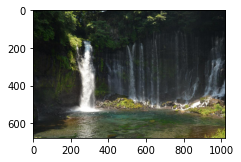

In [ ]:
import numpy as np
from PIL import Image
query_image_pillow=Image.open(f'{IMAGES_PATH}/00000061_(6).jpg').convert('RGB')
query_image_features=get_features(query_image_pillow)
show_images([np.array(query_image_pillow)])
print(query_image_features.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


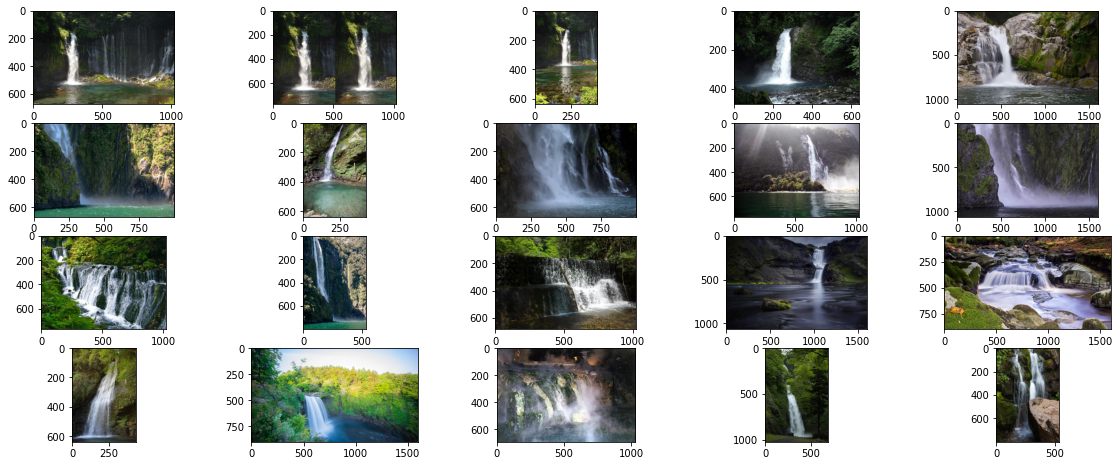

In [ ]:
from sklearn.neighbors import NearestNeighbors
from os import listdir
import numpy as np
import pickle as pk
import json
from pathlib import Path

image_features=pk.load( open("resnet_image_features.pkl", "rb"))
features=[]
for image in image_features:
    features.append(np.array(image['features']))
features=np.array(features)
features=np.squeeze(features)

path="./scenery"
knn = NearestNeighbors(n_neighbors=20,algorithm='brute',metric='euclidean')
knn.fit(features)
file_names=listdir(path)

indices = knn.kneighbors([query_image_features], return_distance=False)
found_images=[]
for x in indices[0]:
    found_images.append(np.array(Image.open(path+"/"+file_names[x])))
show_images(np.array(found_images))

In [ ]:
!pip install hnswlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hnswlib: filename=hnswlib-0.5.1-cp37-cp37m-linux_x86_64.whl size=1296758 sha256=2f6d2688a8ac3d9450e452a3952bd55452ffc2f0ef1c479b9f7c77884f2f6a7e
  Stored in directory: /root/.cache/pip/wheels/46/7b/98/44c3a8a284506a54993f0b321e4a32a0c9e69215bbb72feff5
Successfully built hnswlib


In [ ]:
import hnswlib
dim=2048
index = hnswlib.Index(space='l2', dim=dim)
index.init_index(max_elements=10000, ef_construction=100, M=16)
index.add_items(features)

In [ ]:
%%time
labels, distances = index.knn_query([query_image_features], k = 20)

CPU times: user 1.11 ms, sys: 7 µs, total: 1.11 ms
Wall time: 5.79 ms


[2580 3070 2634   85 2052 1366  804 2847  620 3602 2468 2839 1961 1741
  516 2191 3459 2368  382 3342]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


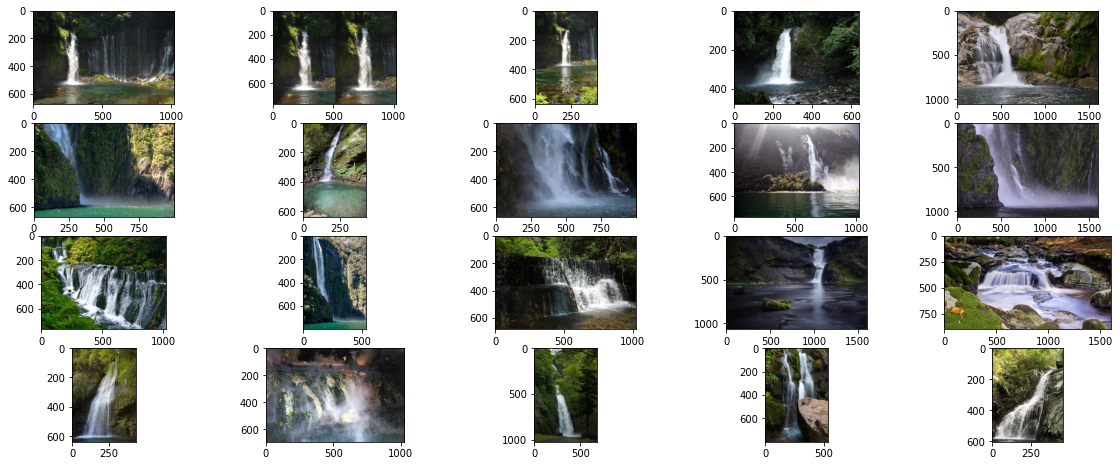

In [ ]:
images_np_hnsw=[]
labels=labels[0]
print(labels)
for idx in labels:
  images_np_hnsw.append(np.array(Image.open(f'{IMAGES_PATH}/{file_names[idx]}')))
show_images(np.array(images_np_hnsw))

[2580 3070 1366  135 2634 1364  706 3013  644 2680 3424 2037 2339  516
  701 2839 2826 1358 3459 3913]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


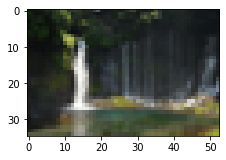

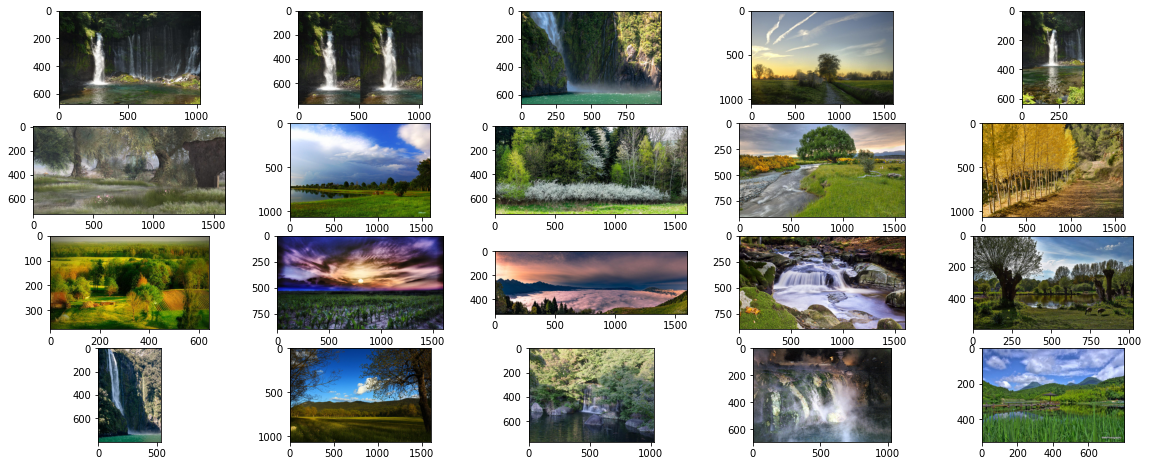

In [ ]:
width, height = query_image_pillow.size
query_image_resized=query_image_pillow.resize((width//19, height//19))
query_image_resized_features=get_features(query_image_resized)
show_images([np.array(query_image_resized)])
labels, distances = index.knn_query([query_image_resized_features], k = 20)
images_np_hnsw_2=[]
labels=labels[0]
print(labels)
for idx in labels:
  images_np_hnsw_2.append(np.array(Image.open(f'{IMAGES_PATH}/{file_names[idx]}')))
show_images(np.array(images_np_hnsw_2))

[2468 2580  140 3165  382  683 2338 1787 3070 1208 1961 3431  911 3342
 2191 4043  516 2009 3964  620]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


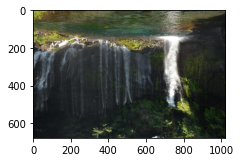

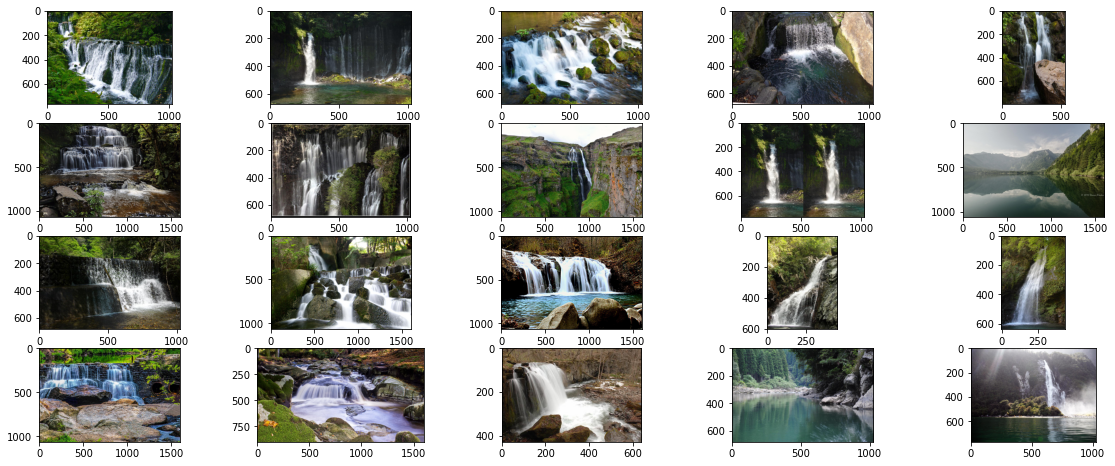

In [ ]:
query_image_rotated = query_image_pillow.rotate(180)
query_image_rotated_features=get_features(query_image_rotated)
show_images([np.array(query_image_rotated)])
labels, distances = index.knn_query([query_image_rotated_features], k = 20)
images_np_hnsw_3=[]
labels=labels[0]
print(labels)
for idx in labels:
  images_np_hnsw_3.append(np.array(Image.open(f'{IMAGES_PATH}/{file_names[idx]}')))
show_images(np.array(images_np_hnsw_3))

[2580 3070 2338 2847 1961 2468  764 1787 3602 1364 2191 3862 1366 3499
 4227  683 2184 3165 3747  620]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


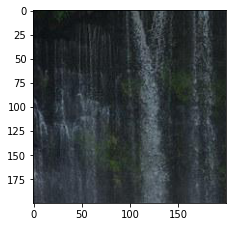

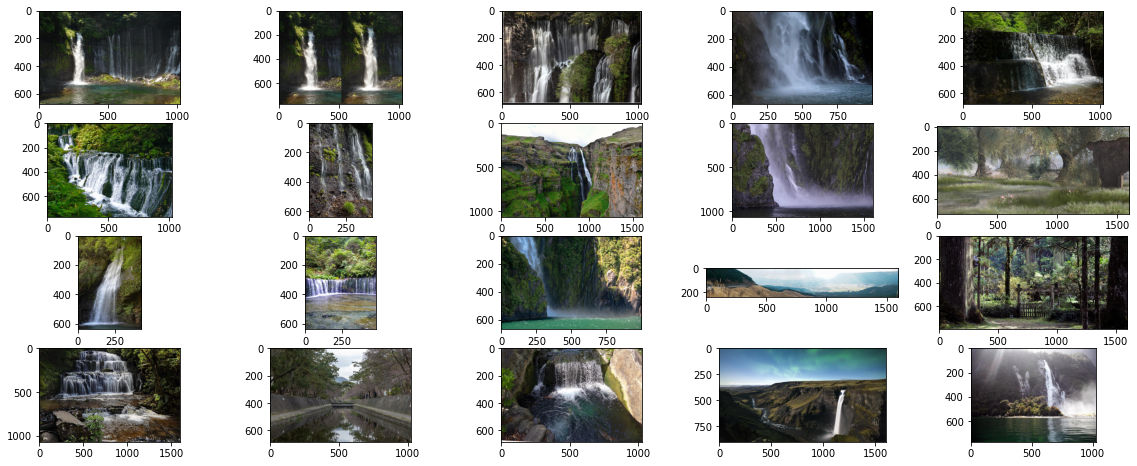

In [ ]:
crop_rectangle = (400, 200, 600, 400)
query_image_cropped = query_image_pillow.crop(crop_rectangle)
query_image_cropped_features=get_features(query_image_cropped)
show_images([np.array(query_image_cropped)])
labels, distances = index.knn_query([query_image_cropped_features], k = 20)
images_np_hnsw_4=[]
labels=labels[0]
print(labels)
for idx in labels:
  images_np_hnsw_4.append(np.array(Image.open(f'{IMAGES_PATH}/{file_names[idx]}')))
show_images(np.array(images_np_hnsw_4))

In [ ]:
!pip install git+https://github.com/qwertyforce/Embeddings2Image.git@patch-1

  Cloning https://github.com/qwertyforce/Embeddings2Image.git (to revision patch-1) to /tmp/pip-req-build-66l58gop
  Running command git clone -q https://github.com/qwertyforce/Embeddings2Image.git /tmp/pip-req-build-66l58gop
  Running command git checkout -b patch-1 --track origin/patch-1
  Switched to a new branch 'patch-1'
  Branch 'patch-1' set up to track remote branch 'patch-1' from 'origin'.
     |████████████████████████████████| 81kB 6.3MB/s 
     |████████████████████████████████| 1.2MB 16.1MB/s 
  Created wheel for Embeddings2Image: filename=Embeddings2Image-0.0.1-cp37-none-any.whl size=8429 sha256=57a06d23f5789426e573c4d25a6836426f72c1d22754cdd109376401445ab87f
  Stored in directory: /tmp/pip-ephem-wheel-cache-p9rzk5ct/wheels/d7/d4/43/88fad4a5afa0d7b94052ba2cecd345ebe619afc89fd26904e1
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=41113aa27c028301b0b692b7450350c6e7d08870d5704573a377f691d490ec59
  Stored in directory: /root/.cac

In [ ]:
import os
from tqdm import tqdm
from e2i import EmbeddingsProjector
import numpy as np
import h5py
import pickle as pk
data_path = 'data.hdf5'
output_path = 'output_plot'
full_file_names=list(map(lambda el: IMAGES_PATH+"/"+el,file_names))
with h5py.File(data_path, 'w') as hf:
    hf.create_dataset('urls', data=np.asarray(full_file_names).astype("S"))
    hf.create_dataset('vectors', data=features)
    hf.close()

In [ ]:
image = EmbeddingsProjector()
image.path2data = data_path
image.load_data()
image.each_img_size = 100
image.output_img_size =  10000
image.calculate_projection()
image.output_img_name = output_path
image.output_img_type = 'scatter'
image.create_image()
print(image.image_list)
print('done!')

dimension reduction using svd
dimension before: 2048
dimension after: 50


100%|██████████| 4319/4319 [00:51<00:00, 83.89it/s]


['./scenery/00000230_(2).jpg', './scenery/00000512_(2).jpg', './scenery/00000200_(6).jpg', './scenery/00000802.jpg', './scenery/00000343_(4).jpg', './scenery/00000839_(3).jpg', './scenery/00000036_(3).jpg', './scenery/00000129_(2).jpg', './scenery/00000844_(2).jpg', './scenery/00000198_(2).jpg', './scenery/00000030.jpg', './scenery/00000232_(3).jpg', './scenery/00000002_(6).jpg', './scenery/00000311_(6).jpg', './scenery/00000388_(2).jpg', './scenery/00000265_(5).jpg', './scenery/00000251_(4).jpg', './scenery/00000290_(3).jpg', './scenery/00000241_(2).jpg', './scenery/00000282.jpg', './scenery/00000591_(4).jpg', './scenery/00000092_(2).jpg', './scenery/00000405.jpg', './scenery/00000481.jpg', './scenery/00000220_(4).jpg', './scenery/00000297.jpg', './scenery/00000182_(5).jpg', './scenery/00000392_(3).jpg', './scenery/00000047_(4).jpg', './scenery/00000464_(4).jpg', './scenery/00000832.jpg', './scenery/00000173_(3).jpg', './scenery/00000211_(3).jpg', './scenery/00000400_(5).jpg', './scen